In [5]:
import pandas
import warnings
from datetime import timedelta as td
from tabulate import tabulate
from datetime import datetime
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from co2sizing import clustering, models, utils


In [6]:

def pretty_display(df):
    print(tabulate(df, headers='keys', tablefmt='psql'))

# Import data into DataFrame

In [7]:
### for German Data , Access file Complete_data_DE.pickle iinstead

complete_data = pandas.read_pickle('../../data/Complete_data_FR.pickle')
pretty_display(complete_data[:10])

+---------------------+-----------+------------+--------------+
| Index               |   cons_kw |   coef_1kw |   co2_kg_kwh |
|---------------------+-----------+------------+--------------|
| 2019-01-01 00:00:00 |   9.52348 |          0 |       0.025  |
| 2019-01-01 00:15:00 |   9.16374 |          0 |       0.024  |
| 2019-01-01 00:30:00 |   8.77342 |          0 |       0.023  |
| 2019-01-01 00:45:00 |  10.1512  |          0 |       0.0225 |
| 2019-01-01 01:00:00 |   7.89873 |          0 |       0.022  |
| 2019-01-01 01:15:00 |   7.83399 |          0 |       0.022  |
| 2019-01-01 01:30:00 |  11.4844  |          0 |       0.022  |
| 2019-01-01 01:45:00 |  14.9401  |          0 |       0.022  |
| 2019-01-01 02:00:00 |  20.7198  |          0 |       0.022  |
| 2019-01-01 02:15:00 |  36.307   |          0 |       0.0225 |
+---------------------+-----------+------------+--------------+


# Clustering

clustering.py contains methods to:
   * Reshape the data into desired shape (observations)
   * cluster the data and return the desired observations and associated weights
   *save the reduced data as csv or pickle

In [3]:
clustering_ = clustering.clustering(complete_data)

reshaped_data = clustering_.reshape_data()

D:\Anaconda\lib\site-packages\scipy\cluster\vq.py:135: RuntimeWarning: Some columns have standard deviation zero. The values of these columns will not change.
  warnings.warn("Some columns have standard deviation zero. "


## Selecting number of clusters for the available data and observation size

Various methods for determining the Ideal number of clusters for K-mans  approach as detailed by the article below:

https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad

* Elbow Method
* Calinski-Harabasz Method
* Silhouette Method

### Elbow Method

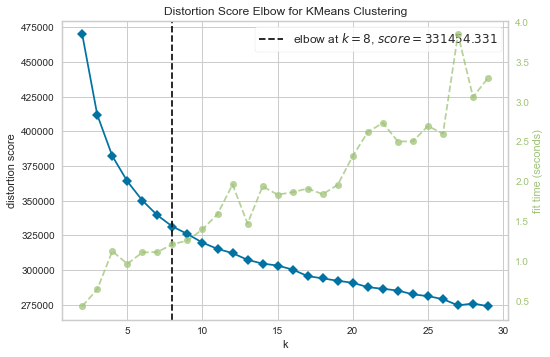

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [4]:
model = KMeans( init='k-means++',n_init=42, max_iter=300, tol=1e-15)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(reshaped_data)        # Fit data to visualizer
visualizer.show() 

### Calinski-Harabasz Method

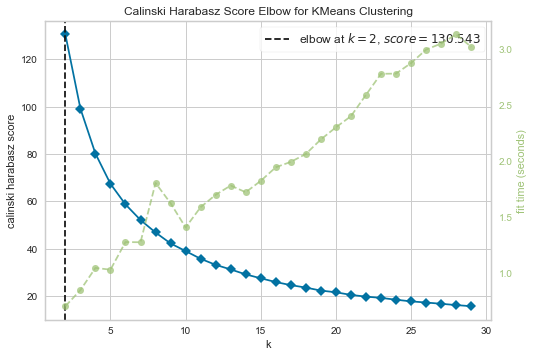

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [5]:
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(reshaped_data)        # Fit the data to the visualizer
visualizer.show() 

### Silhouette Method

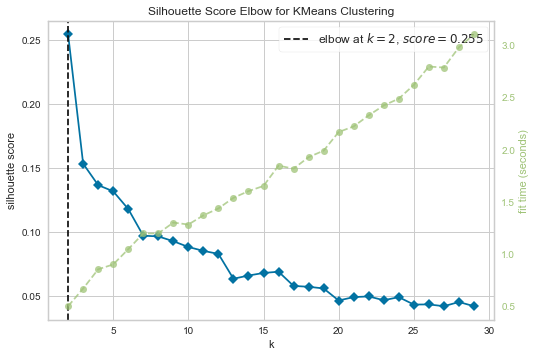

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [6]:
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(reshaped_data)        # Fit the data to the visualizer
visualizer.show()

based on the results of the 3 methods above, 
K-Value of 5 was chosen to ensure that at least most of the seasons (3 out of 4) are represented

In [7]:
clusters, weights = clustering_.cluster(data = reshaped_data, 
                                        n_clusters = 5)
print ("Chosen cluster indexes and associated weights\
       (cluster index : weight) :\n {}".format(weights))

Chosen cluster indexes and associated weights       (cluster index : weight) :
 {52: 11.910614525139666, 243: 11.910614525139666, 30: 10.603351955307264, 117: 5.5195530726256985, 142: 12.05586592178771}


# Save data as pickle file

In [ ]:
# Change file name to reflect your data

clustering_.make_pickle( filepath = "../../data/",
                        file_name = "clustered_data_FR_.pickle")

##### if CSV file is desired instead #####

# clustering_.make_csv( filepath = "../../data/",
#                         file_name = "clustered_data_FR_.csv")


# Tests
To test the effectiveness of the applied clustering method, the optimization is run for both the reduced data and complete data and the CO2 at the end of the period is compared
with the following parameters:
* PV GWP : 1040 kg_CO2_eq/kWh
* Battery GWP: 158 kg_CO2_eq/kWh
* Simulation Period: 20 Years
* Battery SOH: 60% at year 8
* PV deterioration : 90% after 20 years
* Battery Efficiency : 95%


<span style="color:red"> *NOTE* : due to memory usage and computation cost, the tset is carried out over a 1 year Horizon </span>.


In [8]:
import gc

from pyomo.opt import SolverFactory
from pyomo.environ import *
import itertools
def optimize(
    data, nb_years, period_coefs, battery_eta, pv_gwp, battery_gwp, positiv_coefs, self_sufficiency, soh_coefs,
    pv_ageing_coefs, solver='gurobi', verbose=False, solver_path=None,max_soc = 1, min_soc = 0.2,max_pow_in = 0.5 ,
    max_pow_out = 0.5):
    """Optimization model
    """
    ################### Model
    m = ConcreteModel()
    timestep = 15/60

    ###################################################### Set
    m.years = Set(initialize=list(range(0, nb_years)), ordered=True)
    m.periods = Set(initialize=list(range(0, len(data))), ordered=True)
    m.times = Set(initialize=list(range(0, len(data[0]))), ordered=True)
    last = m.times.last()

    ##################################################### Var
    m.pv_capacity = Var(domain=NonNegativeReals)
    m.battery_cap = Var(m.years, domain=NonNegativeReals)
    m.co2_emission = Var(domain=NonNegativeReals)

    # Equipment specifics
    m.gridimport = Var(m.years, m.periods, m.times, domain=NonNegativeReals)
    m.batteryin = Var(m.years, m.periods, m.times, domain=NonNegativeReals)
    m.batteryout = Var(m.years, m.periods, m.times, domain=NonNegativeReals)
    m.batteryenergy = Var(m.years, m.periods, m.times, domain=NonNegativeReals)
    m.pv_curtailed = Var(m.years, m.periods, m.times, domain=NonNegativeReals)

    #################################################### Param
    m.self_sufficiency = Param(initialize=self_sufficiency)
    m.pv_gwp = Param(initialize=pv_gwp)
    m.battery_gwp = Param(initialize=battery_gwp)
    soh_coefs = list(itertools.chain.from_iterable([soh_coefs for i in range(3)]))

    #################################################### Rules
    # --------------------------------------------------------
    # ---------------------Battery----------------------------
    # --------------------------------------------------------
    def r_battery_max_powerin(m, y, p, t):
        return (m.batteryin[y, p, t] <= m.battery_cap[y] * max_pow_in)

    def r_battery_max_powerout(m, y, p, t):
        return (m.batteryout[y, p, t] <= m.battery_cap[y] * max_pow_out)

    def r_battery_energy(m, y, p, t):
        if t == 0:
            return m.batteryenergy[y, p, t] == m.battery_cap[y]/2
        else:
            return (m.batteryenergy[y, p, t] ==
                    m.batteryenergy[y, p, t-1]+ #* (1 - 1e-6)+  # avoid oscillations between pv curtailed and battery
                    m.batteryin[y, p, t-1]
                    * timestep * battery_eta
                    - m.batteryout[y, p, t-1]
                    * timestep / battery_eta)

    def r_battery_capacity_yearly(m, y):
        
        if nb_years ==1:
            return Constraint.Skip
        else:
            if y == 0:
                return Constraint.Skip
            elif y < 8:
                return (m.battery_cap[0] * soh_coefs[y] == m.battery_cap[y])
            elif y == 8:
                return Constraint.Skip
            elif y < 16:
                return (m.battery_cap[8] * soh_coefs[y] == m.battery_cap[y])
            elif y == 16:
                return Constraint.Skip
            elif y > 16:
                return (m.battery_cap[16] * soh_coefs[y] == m.battery_cap[y])

    def r_battery_min_energy(m, y, p, t):
        return (m.batteryenergy[y, p, t] >= m.battery_cap[y] * min_soc)

    def r_battery_max_energy(m, y, p, t):
        return (m.batteryenergy[y, p, t] <= m.battery_cap[y] * max_soc)

    def r_battery_end_energy(m, y, p):
        return (m.batteryenergy[y, p, last] >= m.battery_cap[y]/2)
    
    def r_battery_charge(m, y, p,t):
        return (m.batteryin[y, p, t] <= m.pv_capacity * data[p]['coef_1kw'][t] * pv_ageing_coefs[y])
    # --------------------------------------------------------
    # ------------------Grid imports--------------------------
    # --------------------------------------------------------
    def r_grid_import(m, y, p, t):
        return (m.gridimport[y, p, t] ==
                positiv_coefs[y] * data[p]['cons_kw'][t]
                - m.pv_capacity * data[p]['coef_1kw'][t] * pv_ageing_coefs[y]
                + m.pv_curtailed[y, p, t]
                + m.batteryin[y, p, t] - m.batteryout[y, p, t])

    def r_pv_curtailed(m, y, p, t):
        return (m.pv_curtailed[y, p, t] <= m.pv_capacity * data[p]['coef_1kw'][t] * pv_ageing_coefs[y])

    def r_self_suff(m):
        return (sum(sum(sum(m.gridimport[y, p, t] for t in m.times) for p in m.periods) for y in m.years)
             /  sum(sum(sum(positiv_coefs[y] * data[p]['cons_kw'][t] for t in m.times) for p in m.periods) for y in m.years)
             == 1 - m.self_sufficiency)

    def r_emission(m):
        
        
        return ((m.pv_gwp * m.pv_capacity + m.battery_gwp * m.battery_cap[0] +
                sum(sum(period_coefs[p] * sum(
                m.gridimport[y, p, t] * data[p]['co2_kg_kwh'][t] * timestep
                for t in m.times) for p in m.periods) for y in m.years)) == m.co2_emission)
    # --------------------------------------------------------
    # ---------------------Add To Model-----------------------
    # --------------------------------------------------------
    # Battery
    m.r1 = Constraint(m.years, m.periods, m.times, rule=r_battery_max_powerin)
    m.r2 = Constraint(m.years, m.periods, m.times, rule=r_battery_max_powerout)
    m.r3 = Constraint(m.years, m.periods, m.times, rule=r_battery_energy)
    m.r4 = Constraint(m.years, m.periods, m.times, rule=r_battery_min_energy)
    m.r5 = Constraint(m.years, m.periods, m.times, rule=r_battery_max_energy)
    m.r6 = Constraint(m.years, m.periods, rule=r_battery_end_energy)
    m.r7 = Constraint(m.years, rule=r_battery_capacity_yearly)
    m.r17 = Constraint(m.years,m.periods, m.times, rule=r_battery_charge)
    # Grid imports
    m.r8 = Constraint(m.years, m.periods, m.times, rule=r_grid_import)
    m.r9 = Constraint(m.years, m.periods, m.times, rule=r_pv_curtailed)
    m.r10 = Constraint(rule=r_self_suff)
    m.r11 = Constraint(rule=r_emission)

    ##################################################### Objective function
    # Linear objective function
    def objective_function(m):
        return m.co2_emission
    
    m.objective = Objective(rule=objective_function, sense=minimize)
    #################################################### Run
    # Solve optimization problem
    with SolverFactory(solver, executable=solver_path) as opt:
        results = opt.solve(m, tee=False)
        if verbose:
            print(results)
    return m


In [9]:

reduced_data = []
for index, frame in clusters.groupby("Cluster_number"):
    reduced_data.append(frame.copy())
    
self_production = [0 , 0.7]
reduced, complete = [] , []

soh = [1.0*0.93**n for n in range(8)]
pv_ageing = [1 - 0.005 * i for i in range(20)]
postive_feedback = [1.0*0.97**n for n in range(0, 20)]
period_coef = [weights[reduced_data[i]["Cluster_number"].iloc[0]]\
                   for i in range (len(reduced_data))]
inputs = {
    "nb_years": 1 ,
    'pv_gwp': 1040,  # kgCo2/kW
    'battery_gwp': 158,  # kgCO2/kWh, lifetime = 8 years (4 years discounted)
    'battery_eta': 0.95,
    "soh_coefs": soh,
    "pv_ageing_coefs": pv_ageing,
    "positiv_coefs": postive_feedback
}

for sp in self_production :
    inputs['self_sufficiency'] = sp
    inputs['period_coefs'] = [weights[reduced_data[i]["Cluster_number"].iloc[0]]\
                   for i in range (len(reduced_data))]
    
    model = optimize(reduced_data, **inputs, verbose=False, solver = "gurobi")
    reduced.append(model.co2_emission.value)
    
    inputs['period_coefs'] = [1]
    
    model = optimize([complete_data], **inputs, verbose=False, solver = "gurobi")
    complete.append(model.co2_emission.value)
    del model
    gc.collect()
    

results = pandas.DataFrame({"Self-Sufficiency": self_production,
              "Complete_Data" : complete,
              "Reduced_Data" : reduced})
results["% Deviation"] = abs((1 - results["Reduced_Data"]/ results["Complete_Data"]) *100)



In [10]:
pretty_display(results)

+----+--------------------+-----------------+----------------+---------------+
|    |   Self-Sufficiency |   Complete_Data |   Reduced_Data |   % Deviation |
|----+--------------------+-----------------+----------------+---------------|
|  0 |                0   |         8164.37 |        8166.41 |     0.0250307 |
|  1 |                0.7 |       148755    |      174820    |    17.5217    |
+----+--------------------+-----------------+----------------+---------------+
